In [1]:
!pip install kaggle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! mkdir ~/.kaggle

In [4]:
!cp /content/kaggle.json  ~/.kaggle/kaggle.json

cp: cannot stat '/content/kaggle.json': No such file or directory


In [5]:
! chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [6]:
!kaggle datasets download -d ninadaithal/imagesoasis

Dataset URL: https://www.kaggle.com/datasets/ninadaithal/imagesoasis
License(s): apache-2.0
 98% 1.21G/1.23G [00:09<00:00, 98.6MB/s]
100% 1.23G/1.23G [00:09<00:00, 138MB/s] 


In [7]:
!unzip imagesoasis.zip -d /content/dataset/

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_102.jpg  
  inflating: /content/dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_103.jpg  
  inflating: /content/dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_104.jpg  
  inflating: /content/dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_105.jpg  
  inflating: /content/dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_106.jpg  
  inflating: /content/dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_107.jpg  
  inflating: /content/dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_108.jpg  
  inflating: /content/dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_109.jpg  
  inflating: /content/dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_110.jpg  
  inflating: /content/dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_111.jpg  
  inflating: /content/dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_112.jpg  
  inflating: /content/dat

In [8]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
import re
import os
import random
import tensorflow as tf
import plotly.express as px

from keras.models import Sequential
from PIL import Image
from keras.layers import Conv2D,Flatten,Dense,Dropout,BatchNormalization,MaxPooling2D
from sklearn.preprocessing import OneHotEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, average_precision_score, confusion_matrix, roc_auc_score, f1_score, confusion_matrix, precision_recall_fscore_support
from tensorflow.keras.applications import EfficientNetB0, EfficientNetV2B1
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import clone_model
from matplotlib.colors import LogNorm, LinearSegmentedColormap
from PIL import Image
from scipy.stats import skew
from tqdm import tqdm

In [9]:
# Four categories
non_demented = []
very_mild_demented = []
mild_demented = []
moderate_demented = []

# Download per category
for dirname, _, filenames in os.walk('/content/dataset/Data/Non Demented'):
    for filename in filenames:
        non_demented.append(os.path.join(dirname, filename))

for dirname, _, filenames in os.walk('/content/dataset/Data/Very mild Dementia'):
    for filename in filenames:
        very_mild_demented.append(os.path.join(dirname, filename))

for dirname, _, filenames in os.walk('/content/dataset/Data/Mild Dementia'):
    for filename in filenames:
        mild_demented.append(os.path.join(dirname, filename))

for dirname, _, filenames in os.walk('/content/dataset/Data/Moderate Dementia'):
    for filename in filenames:
        moderate_demented.append(os.path.join(dirname, filename))


In [10]:
# How many samples in each category:
print(len(non_demented))
print(len(very_mild_demented))
print(len(mild_demented))
print(len(moderate_demented))

67222
13725
5002
488


In [11]:
#Exploratory Data Analysis (EDA)

def get_info_from_filename(filename):
    pattern = re.compile('OAS1_(\d+)_MR(\d+)_mpr-(\d+)_(\d+).jpg')
    match = pattern.match(filename)
    patient_id = match.group(1)
    mr_id = match.group(2)
    scan_id = match.group(3)
    layer_id = match.group(4)

    return patient_id, mr_id, scan_id, layer_id

In [12]:
def create_ref_df(dataset_path):
    paths, labels = [], []
    patient_ids, mr_ids, scan_ids, layer_ids = [], [], [], []

    # Iterate through folders in the dataset_path
    for folder in os.listdir(dataset_path):

        # Iterate through files in each folder
        for file in os.listdir(os.path.join(dataset_path, folder)):

            # Extract information from the filename using get_info_from_filename function
            patient_id, mr_id, scan_id, layer_id = get_info_from_filename(file)

            # Append information to respective lists
            paths.append(os.path.join(dataset_path, folder, file))
            labels.append(folder)
            patient_ids.append(patient_id)
            mr_ids.append(mr_id)
            scan_ids.append(scan_id)
            layer_ids.append(layer_id)

    # Create a DataFrame from the collected information
    ref_df = pd.DataFrame({
        'path': paths,
        'label': labels,
        'patient_id': patient_ids,
        'mr_id': mr_ids,
        'scan_id': scan_ids,
        'layer_id': layer_ids
    })

    # Convert columns to appropriate data types
    ref_df = ref_df.astype({
        'path': 'string',
        'label': 'string',
        'patient_id': 'int64',
        'mr_id': 'int64',
        'scan_id': 'int64',
        'layer_id': 'int64'
    })

    return ref_df

In [13]:
# Applying the function defined above
ref_df = create_ref_df('/content/dataset/Data')

In [14]:
def load_images(ref_df):
    labels = []
    images = []
    paths = []

    # Iterate through rows of the reference DataFrame
    for idx, row in tqdm(ref_df.iterrows(), total=ref_df.shape[0]):

        # Load image using PIL and convert it to a grayscale numpy array
        images.append(np.array(Image.open(row['path']).convert('L')))

        # Append label and path to respective lists
        labels.append(row['label'])
        paths.append(row['path'])

    # Return lists of images, labels, and paths
    return images, labels, paths

In [15]:
# Applying the function defined above
images, labels, paths = load_images(ref_df)

100%|██████████| 86437/86437 [01:36<00:00, 892.17it/s]


In [16]:
def get_image_stats(images, labels, paths):
    means, stds, widths, heights = [], [], [], []
    skewnesses = []

    # Iterate through the images
    for image in tqdm(images):

        # Calculate mean and standard deviation
        means.append(np.mean(image))
        stds.append(np.std(image))

        # Get image width and height
        widths.append(image.shape[0])
        heights.append(image.shape[1])

        # Calculate skewness of the image histogram
        image_hist = np.histogram(image.flatten())[0]
        skewnesses.append(skew(image_hist))

    # Create a DataFrame with image statistics
    image_stats = pd.DataFrame({
        'mean': means,
        'std': stds,
        'width': widths,
        'height': heights,
        'skew': skewnesses
    })

    # Add labels and paths to the DataFrame
    image_stats['label'] = labels
    image_stats['path'] = paths

    return image_stats

In [17]:
# Applying the function defined above
image_stats = get_image_stats(images, labels, paths)

100%|██████████| 86437/86437 [03:51<00:00, 372.67it/s]


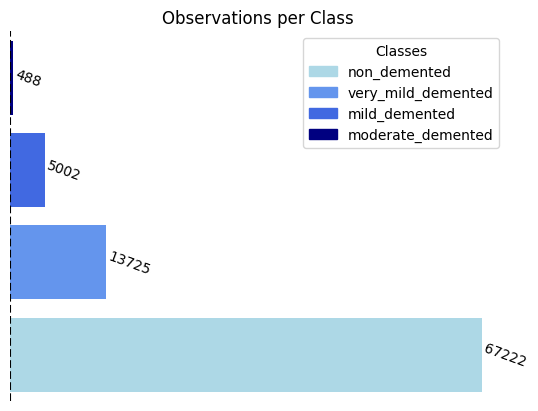

In [18]:
# Defining class_names, frequencies
frequencies = [len(non_demented),  len(very_mild_demented), len(moderate_demented), len(mild_demented),]
class_names = ["non_demented", "very_mild_demented", "moderate_demented", "mild_demented"]

# Sorting class_names and frequencies in descending order
sorted_indices = np.argsort(frequencies)[::-1]
class_names = np.array(class_names)[sorted_indices]
frequencies = np.array(frequencies)[sorted_indices]

# Navy blue gradient color palette with 4 distinct colors
navy_blue_palette = LinearSegmentedColormap.from_list("navy_blue_palette", ["lightblue", "cornflowerblue", "royalblue", "navy"], N=4)

# Bar plot with adjusted y-axis limits and navy blue gradient colors
fig, ax = plt.subplots()
bp = ax.barh(np.arange(len(class_names)), frequencies, color=navy_blue_palette(np.linspace(0, 1, len(class_names))))

# Adjusted y-axis limits
ax.set_ylim(-0.5, len(class_names)-0.5)

# Class names as y-axis labels
ax.set_yticks(np.arange(len(class_names)))
ax.set_yticklabels(class_names)

# Hide axes
ax.axis('off')

# Frequency values to the right of each bar with a reduced offset
for i, frequency in enumerate(frequencies):
    ax.text(frequency + 0.1, i, frequency, ha='left', va='center', rotation=-20)

# Vertical line at 0 for clarity
ax.axvline(x=0, linestyle='--', color='black')

# Legend
handles = [plt.Rectangle((0, 0), 1, 1, color=navy_blue_palette(i)) for i in range(4)]
ax.legend(handles, class_names, loc="upper right", title="Classes")

# Plot title
plt.title("Observations per Class")

plt.show()

In [19]:
# Boxplot of image histogram Means
px.box(image_stats, y='mean', x='label')

Output hidden; open in https://colab.research.google.com to view.

In [20]:
# Boxplot of image histogram SDs
px.box(image_stats, y='std', x='label')

Output hidden; open in https://colab.research.google.com to view.

In [21]:
# Boxplot of image histogram Skewness
px.box(image_stats, y='skew', x='label')

Output hidden; open in https://colab.research.google.com to view.

In [22]:
# Set seed for random sampling
random.seed(42)


# Split off a test set for the moderate_demented class
moderate_demented_train, moderate_demented_test = train_test_split(
    moderate_demented, test_size=0.2, random_state=42
)

# Split off a test set for the mild_demented class
mild_demented_train, mild_demented_test = train_test_split(
    mild_demented, test_size=0.2, random_state=42
)

# Split off a test set for the very_mild_demented class
very_mild_demented_train, very_mild_demented_test = train_test_split(
    very_mild_demented, test_size=0.2, random_state=42
)

# Split off a test set for the non_demented class
non_demented_train, non_demented_test = train_test_split(
    non_demented, test_size=0.2, random_state=42
)

In [23]:
# Check number of train images per category
print(len(non_demented_train))
print(len(very_mild_demented_train))
print(len(mild_demented_train))
print(len(moderate_demented_train))

53777
10980
4001
390


In [24]:
# Specify the target number of samples for each class
target_samples = 2500

# Oversample small classes
moderate_demented_samp = random.choices(moderate_demented_train, k=target_samples)


# Undersample large classes
very_mild_demented_samp = random.sample(very_mild_demented_train, k=target_samples)
non_demented_samp = random.sample(non_demented_train, k=target_samples)
mild_demented_samp = random.sample(mild_demented_train, k=target_samples)

In [25]:
# Check results
print(len(non_demented_samp))
print(len(very_mild_demented_samp))
print(len(mild_demented_samp))
print(len(moderate_demented_samp))

2500
2500
2500
2500


In [26]:
# Check the number of test images per category
print(len(non_demented_test))
print(len(very_mild_demented_test))
print(len(mild_demented_test))
print(len(moderate_demented_test))

13445
2745
1001
98


In [27]:
# Specify the target number of samples for each class
target_samples = 500

# Oversample large classes
moderate_demented_test = random.choices(moderate_demented_test, k=target_samples)

# Undersample large classes
mild_demented_test = random.sample(mild_demented_test, k=target_samples)
very_mild_demented_test = random.sample(very_mild_demented_test, k=target_samples)
non_demented_test = random.sample(non_demented_test, k=target_samples)

In [28]:
# One-hot encoder for class labels
encoder = OneHotEncoder()
encoder.fit([[0],[1],[2],[3]])

OneHotEncoder()

In [29]:
# Empty objects to store the data and the class labels (result) in
data = []
result = []

# Loop through each category and transform data and result into right format (128x128x3 & one-hot encoded)
# and merge categories together
for path in non_demented_samp:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[0]]).toarray())

for path in very_mild_demented_samp:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[1]]).toarray())

for path in mild_demented_samp:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[2]]).toarray())

for path in moderate_demented_samp:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[3]]).toarray())

In [30]:
# Transform data to numpy array
data = np.array(data)

# Check shape
data.shape

(10000, 128, 128, 3)

In [31]:
# Transform labels to numpy array
result = np.array(result)

# Reshape to the one-hot encoded format
result = result.reshape((data.shape[0],4))

# Check shape
result.shape

(10000, 4)

In [32]:
# Split in validation and train data
x_train,x_val,y_train,y_val = train_test_split(data,result, test_size=0.20, shuffle=True, random_state=42)

In [33]:
### Transforming the data into the right shape (128x128x3), merge and encode it

data_test = []
result_test = []

for path in non_demented_test:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data_test.append(np.array(img))
        result_test.append(encoder.transform([[0]]).toarray())

for path in very_mild_demented_test:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data_test.append(np.array(img))
        result_test.append(encoder.transform([[1]]).toarray())

for path in mild_demented_test:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data_test.append(np.array(img))
        result_test.append(encoder.transform([[2]]).toarray())

for path in moderate_demented_test:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data_test.append(np.array(img))
        result_test.append(encoder.transform([[3]]).toarray())

In [34]:
# Transform data to numpy array
data_test = np.array(data_test)
data_test.shape

(2000, 128, 128, 3)

In [35]:
# Transform labels to numpy array
result_test = np.array(result_test)
result_test = result_test.reshape((data_test.shape[0],4))
result_test.shape

(2000, 4)

In [36]:
# Change names to x_test and y_test
x_test = data_test
y_test = result_test

In [37]:
# Convert labels to integers
y_train_int = np.argmax(y_train, axis=1)
y_val_int = np.argmax(y_val, axis=1)

In [38]:
import numpy as np
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

# Define Xception model
def build_xception(input_shape=(128, 128, 3), num_classes=4):
    base_model = Xception(include_top=False, weights='imagenet', input_shape=input_shape)
    x = base_model.output
    x = Flatten()(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output_layer)

    # Freeze the layers of Xception base model
    for layer in base_model.layers:
        layer.trainable = False

    return model

# Build the model
xception_model = build_xception()

# Compile the model
xception_model.compile(optimizer=Adam(learning_rate=1e-4),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# Define callbacks
checkpoint = ModelCheckpoint('/content/drive/MyDrive/BEST128o2500final_xception_best_model.h5',
                             save_best_only=True,
                             monitor='val_loss',
                             mode='min')

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Train the model
history = xception_model.fit(x_train, y_train,
                             validation_data=(x_val, y_val),
                             epochs=50,
                             batch_size=32,
                             callbacks=[checkpoint, early_stopping])

# Evaluate the model
y_pred = xception_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Classification report
report = classification_report(y_test_classes, y_pred_classes, target_names=class_names, output_dict=True)
print("Classification Report:")
print("Accuracy: {:.2f}".format(report['accuracy']))
print("Precision per class:")
for class_name, metrics in report.items():
    if class_name == 'accuracy':
        continue
    print(f"{class_name}: Precision = {metrics['precision']:.2f}")
print("Recall per class:")
for class_name, metrics in report.items():
    if class_name == 'accuracy':
        continue
    print(f"{class_name}: Recall = {metrics['recall']:.2f}")
print("F1 Score per class:")
for class_name, metrics in report.items():
    if class_name == 'accuracy':
        continue
    print(f"{class_name}: F1 Score = {metrics['f1-score']:.2f}")


83683744/83683744 [==============================] - 0s 0us/step
Epoch 1/50
250/250 [==============================] - ETA: 0s - loss: 4.5937 - accuracy: 0.5136

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



250/250 [==============================] - 237s 936ms/step - loss: 4.5937 - accuracy: 0.5136 - val_loss: 1.2318 - val_accuracy: 0.6590
Epoch 2/50
250/250 [==============================] - 219s 876ms/step - loss: 1.2564 - accuracy: 0.6302 - val_loss: 0.7907 - val_accuracy: 0.7075
Epoch 3/50
250/250 [==============================] - 221s 885ms/step - loss: 0.8834 - accuracy: 0.6819 - val_loss: 0.6852 - val_accuracy: 0.7340
Epoch 4/50
250/250 [==============================] - 219s 878ms/step - loss: 0.7876 - accuracy: 0.7031 - val_loss: 0.5415 - val_accuracy: 0.7705
Epoch 5/50
250/250 [==============================] - 210s 841ms/step - loss: 0.6878 - accuracy: 0.7260 - val_loss: 0.6057 - val_accuracy: 0.7750
Epoch 6/50
250/250 [==============================] - 212s 847ms/step - loss: 0.6174 - accuracy: 0.7441 - val_loss: 0.5734 - val_accuracy: 0.7725
Epoch 7/50
250/250 [==============================] - 221s 885ms/step - loss: 0.6335 - accuracy: 0.7498 - val_loss: 0.4707 - val_accura

63/63 [==============================] - 16s 240ms/step
Overall Accuracy: 0.91

Confusion Matrix:
[[390  97  11   2]
 [ 32 451  16   1]
 [  5  16 479   0]
 [  0   0   9 491]]

Classification Report:
Precision per class:
non_demented: Precision = 0.91
very_mild_demented: Precision = 0.80
mild_demented: Precision = 0.93
moderate_demented: Precision = 0.99
macro avg: Precision = 0.91
weighted avg: Precision = 0.91
Recall per class:
non_demented: Recall = 0.78
very_mild_demented: Recall = 0.90
mild_demented: Recall = 0.96
moderate_demented: Recall = 0.98
macro avg: Recall = 0.91
weighted avg: Recall = 0.91
F1 Score per class:
non_demented: F1 Score = 0.84
very_mild_demented: F1 Score = 0.85
mild_demented: F1 Score = 0.94
moderate_demented: F1 Score = 0.99
macro avg: F1 Score = 0.91
weighted avg: F1 Score = 0.91
Mean F1 Score: 0.91


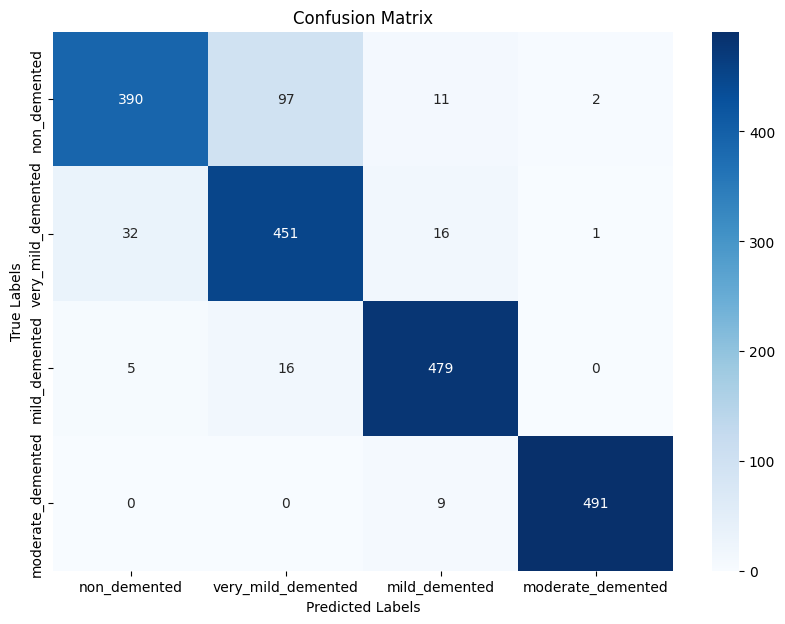

In [39]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Load the best Xception model
model_path = '/content/drive/MyDrive/BEST128o2500final_xception_best_model.h5'
xception_model = load_model(model_path)

# Predict on the test set
y_pred = xception_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test_classes, y_pred_classes)

# Generate classification report
report = classification_report(y_test_classes, y_pred_classes, target_names=class_names, output_dict=True)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

# Print results
print("Overall Accuracy: {:.2f}".format(accuracy))
print("\nConfusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print("Precision per class:")
for class_name, metrics in report.items():
    if isinstance(metrics, dict):  # Only print metrics for classes
        print(f"{class_name}: Precision = {metrics['precision']:.2f}")

print("Recall per class:")
for class_name, metrics in report.items():
    if isinstance(metrics, dict):  # Only print metrics for classes
        print(f"{class_name}: Recall = {metrics['recall']:.2f}")

print("F1 Score per class:")
for class_name, metrics in report.items():
    if isinstance(metrics, dict):  # Only print metrics for classes
        print(f"{class_name}: F1 Score = {metrics['f1-score']:.2f}")

# Calculate mean F1 Score
f1_scores = [metrics['f1-score'] for class_name, metrics in report.items() if isinstance(metrics, dict) and 'f1-score' in metrics]
mean_f1_score = np.mean(f1_scores)
print("Mean F1 Score: {:.2f}".format(mean_f1_score))

# Visualization of the Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


63/63 [==============================] - 16s 243ms/step
Overall Accuracy: 0.91

Confusion Matrix:
[[390  97  11   2]
 [ 32 451  16   1]
 [  5  16 479   0]
 [  0   0   9 491]]

Classification Report:
non_demented: Precision = 0.91, Recall = 0.78, F1 Score = 0.84
very_mild_demented: Precision = 0.80, Recall = 0.90, F1 Score = 0.85
mild_demented: Precision = 0.93, Recall = 0.96, F1 Score = 0.94
moderate_demented: Precision = 0.99, Recall = 0.98, F1 Score = 0.99
macro avg: Precision = 0.91, Recall = 0.91, F1 Score = 0.91
weighted avg: Precision = 0.91, Recall = 0.91, F1 Score = 0.91
Mean F1 Score: 0.91

Overall Metrics:
Overall Precision: 0.91
Overall Recall: 0.91
Overall F1 Score: 0.91


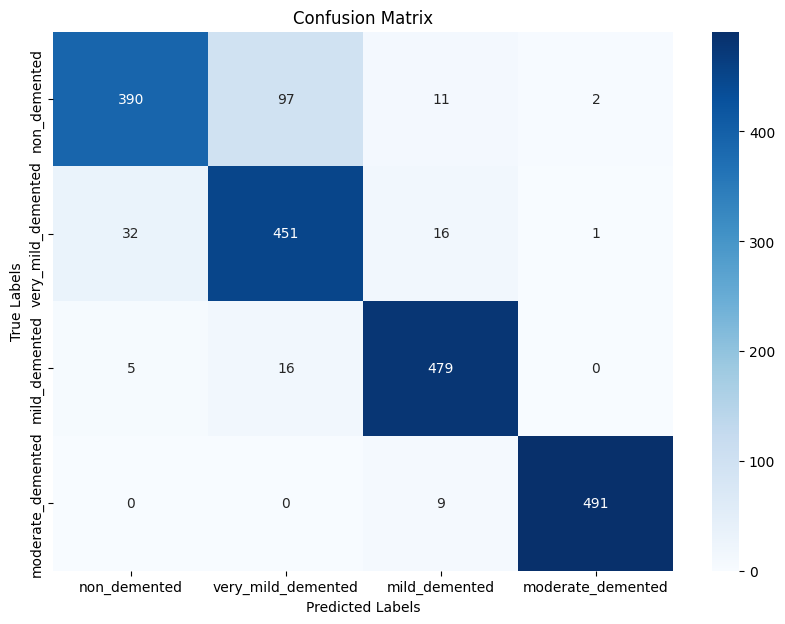

In [40]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Load the best Xception model
model_path = '/content/drive/MyDrive/BEST128o2500final_xception_best_model.h5'
xception_model = load_model(model_path)

# Predict on the test set
y_pred = xception_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test_classes, y_pred_classes)

# Generate classification report
report = classification_report(y_test_classes, y_pred_classes, target_names=class_names, output_dict=True)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

# Print overall results
print("Overall Accuracy: {:.2f}".format(accuracy))

# Print confusion matrix
print("\nConfusion Matrix:")
print(conf_matrix)

# Print classification report
print("\nClassification Report:")
for class_name, metrics in report.items():
    if isinstance(metrics, dict):  # Only print metrics for classes
        print(f"{class_name}: Precision = {metrics['precision']:.2f}, Recall = {metrics['recall']:.2f}, F1 Score = {metrics['f1-score']:.2f}")

# Calculate mean F1 Score
f1_scores = [metrics['f1-score'] for class_name, metrics in report.items() if isinstance(metrics, dict) and 'f1-score' in metrics]
mean_f1_score = np.mean(f1_scores)
print("Mean F1 Score: {:.2f}".format(mean_f1_score))

# Calculate overall precision, recall, and F1 Score
overall_precision = report['accuracy']  # 'accuracy' is actually overall accuracy
overall_recall = report['accuracy']     # 'accuracy' is actually overall accuracy
overall_f1_score = mean_f1_score

# Print overall metrics
print("\nOverall Metrics:")
print(f"Overall Precision: {overall_precision:.2f}")
print(f"Overall Recall: {overall_recall:.2f}")
print(f"Overall F1 Score: {overall_f1_score:.2f}")

# Visualization of the Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
